# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# My additional imports
import logging

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import models
import utils
import importlib
importlib.reload(utils)
importlib.reload(models)
from models import Classifier01, Classifier02


# Initialize logger
import logging
importlib.reload(logging)
logging.basicConfig(level=logging.INFO, format="%(message)s")

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
import torch.utils
import torch.utils.data

# data download directory to use throughout this notebook
cifar10_data_dir = "./cifar10-data"
batch_size = 4

# Split the training data (50k images) into a training set (45k image) and a validation set (5k images)
np.random.seed(42)
indices = np.arange(0,50000)
np.random.shuffle(indices)
train_indices = indices[:45000]
validation_indices = indices[45000:]

# Define transforms
# Training transformations are defined to add some variability to the training set to keep the
# model generalizable.  The normalization transform is set to scale numbers to the range
# [-1.0, 1.0] (see the "Exploration Summary" section)
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])
test_and_validation_transforms = transforms.Compose([transforms.ToTensor(),
                                                     transforms.Normalize([0.5, 0.5, 0.5], 
                                                                          [0.5, 0.5, 0.5])])

# Create training set and define training dataloader
dataset = datasets.CIFAR10(root=cifar10_data_dir, train=True, download=True, transform=train_transforms)
train_dataset = torch.utils.data.Subset(dataset, indices=train_indices)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create validation set and define validation dataloader
dataset = datasets.CIFAR10(root=cifar10_data_dir, train=True, download=False, transform=test_and_validation_transforms)
validation_dataset = torch.utils.data.Subset(dataset, indices=validation_indices)
validation_dataloader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

# Create test set and define test dataloader
test_dataset = datasets.CIFAR10(root=cifar10_data_dir, train=False, download=False, transform=test_and_validation_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
# NOTE: I have modified this from the original function since the original version
#       runs into a NameError with the 'classes' variable and also displayed images
#       rotated 90 degrees off.
def show5(img_dataloader, img_dataset):
    dataiter = iter(img_dataloader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(img_dataset.classes[labels[i]])
    
        image = images[i].numpy()
        #plt.imshow(image.T)
        plt.imshow(np.transpose(image, (1, 2, 0)))
        plt.show()

In [5]:
# collect and display information on all images in the CIFAR-10 training set
df_image_stats, df_label_stats = utils.get_cifar10_image_stats(root=cifar10_data_dir)

display(df_label_stats)
display(df_image_stats.describe())

Files already downloaded and verified


,class_idx,class_name,count
0,0,airplane,5000
1,1,automobile,5000
2,2,bird,5000
3,3,cat,5000
4,4,deer,5000
5,5,dog,5000
6,6,frog,5000
7,7,horse,5000
8,8,ship,5000
9,9,truck,5000


,num_channels,height,width,area,aspect_ratio,chan_0_min_pixel_val,chan_0_mean_pixel_val,chan_0_median_pixel_val,chan_0_max_pixel_val,chan_1_min_pixel_val,chan_1_mean_pixel_val,chan_1_median_pixel_val,chan_1_max_pixel_val,chan_2_min_pixel_val,chan_2_mean_pixel_val,chan_2_median_pixel_val,chan_2_max_pixel_val
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,3.0,32.0,32.0,1024.0,1.0,0.072223,0.491400,0.489938,0.924321,0.069076,0.482158,0.481939,0.909427,0.058475,0.446531,0.438482,0.891862
std,0.0,0.0,0.0,0.0,0.0,0.075864,0.128358,0.166499,0.092047,0.070824,0.125787,0.163195,0.100225,0.067695,0.153319,0.193560,0.129684
min,3.0,32.0,32.0,1024.0,1.0,0.000000,0.009992,0.000000,0.176471,0.000000,0.013840,0.000000,0.200000,0.000000,0.012580,0.000000,0.058824
25%,3.0,32.0,32.0,1024.0,1.0,0.011765,0.407305,0.380392,0.882353,0.011765,0.399558,0.376471,0.854902,0.007843,0.338533,0.301961,0.831373
50%,3.0,32.0,32.0,1024.0,1.0,0.047059,0.486834,0.482353,0.956863,0.047059,0.477541,0.474510,0.941176,0.035294,0.435535,0.411765,0.941176
75%,3.0,32.0,32.0,1024.0,1.0,0.109804,0.570254,0.588235,1.000000,0.105882,0.558508,0.576471,0.996078,0.086275,0.543395,0.552941,0.996078
max,3.0,32.0,32.0,1024.0,1.0,0.647059,0.988944,1.000000,1.000000,0.600000,0.990698,1.000000,1.000000,0.694118,0.991422,1.000000,1.000000


In [6]:
# Display size and shape of the training and test data
len(train_dataset.dataset.targets)
len(validation_dataset.dataset.targets)
print(f"num images in training dataset:   {len(train_dataset)}")
print(f"num images in validation dataset: {len(validation_dataset)}")
print(f"num images in test dataset:       {len(test_dataset)}")

num images in training dataset:   45000
num images in validation dataset: 5000
num images in test dataset:       10000


dog


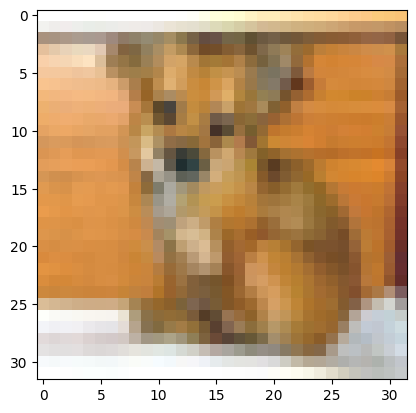

truck


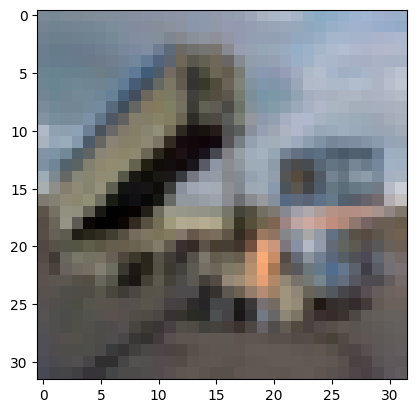

dog


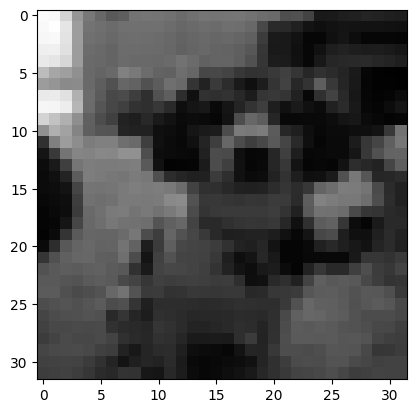

cat


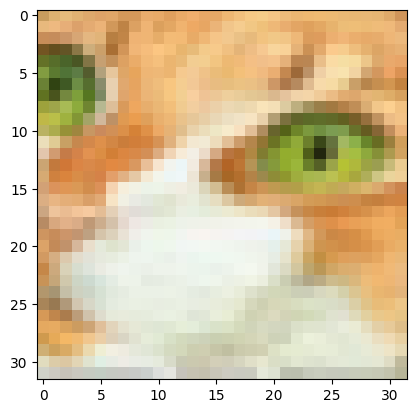

ship


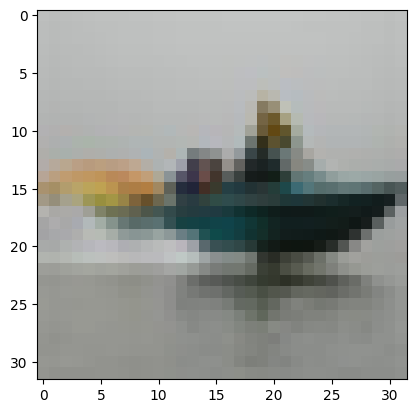

In [7]:
# Display 5 random images from the test set
# create a CIFAR-10 images data loader for display (with only the ToTensor transformation)
display_transform = transforms.Compose([transforms.ToTensor()])
display_dataset = datasets.CIFAR10(root=cifar10_data_dir, train=False, download=False, transform=display_transform)
display_dataloader = DataLoader(display_dataset, batch_size=5, shuffle=True)

show5(display_dataloader, display_dataset)

### Exploration summary

- The training set is evenly balanced between class labels

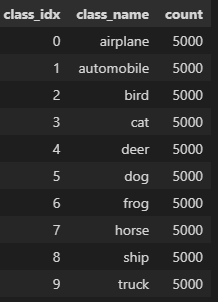

- All images are 32 x 32 with three channels

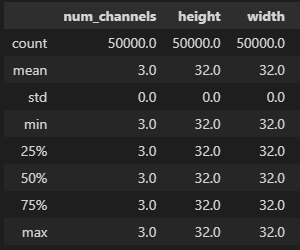

- There are 50k training images, which I have divided into 45k "training" and 5k "validation".  There are 10k test images.

- Pixel values in each channel are in the range [0.0, 1.0].  This means that it would be appropriate to normalize each channel with a "mean" of 0.5 and "standard deviation" of 0.5 to transform values to a range of [-1.0, 1.0].

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

### Code
The models are defined in `models.py`, but are displayed below for simplicity.

```python
class Classifier01(nn.Module):
    """
    Define a simple 5-layer fully-connected neural network
    number of input units = (3 channels) * (32 width) * (32 height) = 3072
    """
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # flatten the input tensor
        x = x.view(x.shape[0], -1)

        # use the rectified linear unit function as the activation function and log softmax to get probabilities
        # of each class at the end
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))

        # output should not have any dropout
        x = F.log_softmax(self.fc5(x), dim=1)
        
        return x

class Classifier02(nn.Module):
    """
    This is a copy and paste from the pytorch tutorial
    https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Classifier03(nn.Module):
    """
    Modified from Classifier02 to have more output channels in the convulutional
    layers and an additional fully connected layer.
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 350)
        self.fc2 = nn.Linear(350, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class Classifier04(nn.Module):
    """
    Modified from Classifier04 to have an additional convulutional layer and an 
    additional output layer.    
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 32, 2)
        self.conv3 = nn.Conv2d(32, 64, 2)
        self.fc1 = nn.Linear(2304, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 84)
        self.fc5 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

class Classifier05(nn.Module):
    """
    Modified from Classifier04 to include dropout. 
    """
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.15)

        self.conv1 = nn.Conv2d(3, 12, 2)
        self.conv2 = nn.Conv2d(12, 32, 2)
        self.conv3 = nn.Conv2d(32, 64, 2)
        self.fc1 = nn.Linear(2304, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 84)
        self.fc5 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(self.dropout(F.relu(self.conv1(x))))
        x = self.dropout(F.relu(self.conv2(x)))
        x = self.pool(self.dropout(F.relu(self.conv3(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.fc5(x)
        return x
```

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [24]:
importlib.reload(models)
importlib.reload(utils)
from models import Classifier01, Classifier02, Classifier03, Classifier04, Classifier05

################
# classifier01 #
################
# model = Classifier01()
# criterion = nn.NLLLoss(reduction="mean")
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

################
# classifier02 #
################
# model = Classifier02()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

################
# classifier03 #
################
# model = Classifier03()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

################
# classifier04 #
################
# model = Classifier04()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

################
# classifier05 #
################
model = Classifier05()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [25]:
# user parameters
num_epochs = 25
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.cpu()

# train model
training_stats_dict = utils.train(model, criterion, optimizer, train_dataloader, validation_dataloader, num_epochs, device)

# save model
output_file_path = "checkpoint.pt"
utils.save_checkpoint(model, train_dataset, training_stats_dict, output_file_path)

epoch       run_time    train_loss  train_acc   valid_loss  valid_acc   
0           52.3        2.1744      0.1600      1.9672      0.2474      
1           51.1        1.8617      0.2836      1.6876      0.3680      
2           51.3        1.6614      0.3826      1.5262      0.4392      
3           50.6        1.5203      0.4471      1.4228      0.4970      
4           50.8        1.4309      0.4825      1.2995      0.5456      
5           50.6        1.3583      0.5124      1.2288      0.5664      
6           50.9        1.3039      0.5354      1.2448      0.5752      
7           50.6        1.2562      0.5508      1.1521      0.5966      
8           50.5        1.2221      0.5685      1.1267      0.6058      
9           50.8        1.1918      0.5804      1.0745      0.6258      
10          51.0        1.1588      0.5909      1.0876      0.6242      
11          50.7        1.1323      0.6001      1.0749      0.6278      
12          50.8        1.1128      0.6101      1.0

### output from running different classifiers

**Classifier01**

```
epoch       run_time    train_loss  train_acc   valid_loss  valid_acc   
0           36.9        2.0315      0.2480      1.8303      0.3378      
1           38.8        1.8617      0.3267      1.7270      0.3874      
2           36.5        1.7972      0.3562      1.6989      0.3930      
3           36.3        1.7554      0.3691      1.6715      0.3906      
4           36.4        1.7189      0.3837      1.6395      0.4158      
5           35.5        1.6927      0.3917      1.5936      0.4278      
6           36.2        1.6687      0.4022      1.5840      0.4302      
7           35.4        1.6466      0.4098      1.5723      0.4380      
8           35.7        1.6319      0.4170      1.5468      0.4448      
9           35.6        1.6228      0.4212      1.5637      0.4438      
10          35.5        1.6123      0.4217      1.5645      0.4434      
11          35.4        1.5944      0.4306      1.5444      0.4434      
12          35.3        1.5915      0.4322      1.5320      0.4496      
13          36.1        1.5843      0.4368      1.5168      0.4552      
14          38.5        1.5767      0.4397      1.5173      0.4592      
15          38.6        1.5651      0.4443      1.5429      0.4466      
16          38.5        1.5549      0.4429      1.5295      0.4548      
17          38.5        1.5531      0.4442      1.5442      0.4530      
18          38.8        1.5462      0.4499      1.5250      0.4518      
19          37.0        1.5386      0.4515      1.5395      0.4536      
total_run_time: 735.5073757171631
```

**Classifier02**

```
epoch       run_time    train_loss  train_acc   valid_loss  valid_acc   
0           40.3        1.9136      0.2903      1.6991      0.3686      
1           35.2        1.6270      0.4064      1.5420      0.4386      
2           35.3        1.5201      0.4488      1.4570      0.4748      
3           35.1        1.4688      0.4685      1.3972      0.4978      
4           34.9        1.4321      0.4839      1.4614      0.4848      
5           34.7        1.4081      0.4922      1.3727      0.5088      
6           34.9        1.3851      0.5021      1.3877      0.5016      
7           35.3        1.3690      0.5080      1.3258      0.5296      
8           35.2        1.3561      0.5146      1.3263      0.5324      
9           34.9        1.3423      0.5214      1.2901      0.5350      
10          35.5        1.3329      0.5213      1.2940      0.5364      
11          35.7        1.3227      0.5274      1.3088      0.5398      
12          35.0        1.3140      0.5307      1.2611      0.5490      
13          34.9        1.3113      0.5345      1.2726      0.5484      
14          35.1        1.3027      0.5304      1.3030      0.5314      
15          34.9        1.2908      0.5400      1.3046      0.5322      
16          34.9        1.2856      0.5404      1.2845      0.5406      
17          35.0        1.2808      0.5397      1.2564      0.5584      
18          34.8        1.2825      0.5424      1.2437      0.5646      
19          34.8        1.2712      0.5476      1.2512      0.5560      
20          34.9        1.2671      0.5484      1.2699      0.5564      
21          34.8        1.2652      0.5520      1.2447      0.5594      
22          34.9        1.2613      0.5518      1.2600      0.5462      
23          34.9        1.2560      0.5544      1.2286      0.5698      
24          35.1        1.2610      0.5500      1.2768      0.5506      
total_run_time: 880.8583290576935
```

**Classifier03**

```
epoch       run_time    train_loss  train_acc   valid_loss  valid_acc   
0           39.6        1.9718      0.2540      1.7006      0.3740      
1           39.4        1.5978      0.4153      1.4700      0.4684      
2           38.7        1.4452      0.4776      1.3854      0.4862      
3           38.9        1.3639      0.5086      1.3196      0.5216      
4           38.3        1.3049      0.5313      1.2301      0.5556      
5           38.8        1.2553      0.5534      1.2711      0.5518      
6           39.3        1.2203      0.5662      1.1796      0.5886      
7           38.4        1.1921      0.5744      1.1862      0.5928      
8           38.8        1.1629      0.5872      1.0702      0.6276      
9           38.5        1.1338      0.5974      1.0990      0.6060      
10          38.7        1.1171      0.6056      1.0469      0.6338      
11          38.2        1.0978      0.6110      1.0604      0.6282      
12          39.5        1.0853      0.6166      1.0284      0.6338      
13          39.1        1.0651      0.6252      1.0590      0.6338      
14          38.3        1.0631      0.6269      0.9929      0.6528      
15          38.5        1.0469      0.6314      1.0314      0.6346      
16          38.1        1.0352      0.6352      1.0210      0.6470      
17          38.3        1.0227      0.6398      1.0743      0.6260      
18          38.7        1.0137      0.6431      1.0454      0.6398      
19          38.9        1.0028      0.6466      1.0447      0.6356      
total_run_time: 775.0359513759613
```

**Classifier04**

```
epoch       run_time    train_loss  train_acc   valid_loss  valid_acc   
0           46.8        2.3030      0.1022      2.2996      0.1004      
1           46.5        2.0468      0.2087      1.7837      0.3076      
2           46.4        1.7502      0.3275      1.5686      0.3930      
3           45.7        1.5569      0.4211      1.4162      0.4816      
4           45.0        1.4250      0.4801      1.2893      0.5256      
5           47.6        1.3270      0.5192      1.1963      0.5750      
6           45.5        1.2487      0.5502      1.1605      0.5862      
7           51.6        1.1890      0.5740      1.1205      0.6042      
8           45.7        1.1339      0.5931      1.0487      0.6266      
9           46.6        1.0893      0.6092      1.0856      0.6246      
10          54.4        1.0485      0.6308      1.0397      0.6318      
11          46.6        1.0160      0.6371      1.0268      0.6372      
12          46.7        0.9878      0.6497      0.9613      0.6654      
13          50.2        0.9606      0.6597      0.9450      0.6714      
14          57.0        0.9339      0.6666      0.9259      0.6780      
15          54.4        0.9099      0.6772      0.9488      0.6712      
16          50.0        0.8908      0.6851      0.9388      0.6666      
17          52.5        0.8667      0.6930      0.9171      0.6918      
18          58.8        0.8533      0.7004      0.9034      0.6942      
19          48.1        0.8274      0.7048      0.9154      0.6862      
total_run_time: 986.1806242465973
```

Continuing to run another 10 epochs
```
epoch       run_time    train_loss  train_acc   valid_loss  valid_acc   
0           47.1        0.8142      0.7117      0.9073      0.6904      
1           45.7        0.7979      0.7182      0.9306      0.6816      
2           46.3        0.7833      0.7230      0.9442      0.6784      
3           45.9        0.7708      0.7306      0.8555      0.7084      
4           46.1        0.7523      0.7336      0.9007      0.6918      
5           46.5        0.7405      0.7385      0.8667      0.7084      
6           46.4        0.7297      0.7432      0.8893      0.6940      
7           53.3        0.7174      0.7476      0.8993      0.6996      
8           52.8        0.7002      0.7509      0.8965      0.6950      
9           45.9        0.6869      0.7564      0.9141      0.6948      
total_run_time: 475.9983422756195
```

**Classifier05**

```
epoch       run_time    train_loss  train_acc   valid_loss  valid_acc   
0           52.3        2.1744      0.1600      1.9672      0.2474      
1           51.1        1.8617      0.2836      1.6876      0.3680      
2           51.3        1.6614      0.3826      1.5262      0.4392      
3           50.6        1.5203      0.4471      1.4228      0.4970      
4           50.8        1.4309      0.4825      1.2995      0.5456      
5           50.6        1.3583      0.5124      1.2288      0.5664      
6           50.9        1.3039      0.5354      1.2448      0.5752      
7           50.6        1.2562      0.5508      1.1521      0.5966      
8           50.5        1.2221      0.5685      1.1267      0.6058      
9           50.8        1.1918      0.5804      1.0745      0.6258      
10          51.0        1.1588      0.5909      1.0876      0.6242      
11          50.7        1.1323      0.6001      1.0749      0.6278      
12          50.8        1.1128      0.6101      1.0516      0.6302      
13          50.4        1.0987      0.6142      1.0179      0.6458      
14          50.3        1.0705      0.6245      0.9979      0.6588      
15          50.5        1.0511      0.6347      1.0401      0.6392      
16          50.5        1.0389      0.6334      0.9687      0.6672      
17          50.8        1.0256      0.6419      1.0322      0.6540      
18          50.9        1.0094      0.6473      0.9848      0.6590      
19          50.5        0.9972      0.6530      0.9280      0.6732      
20          50.4        0.9857      0.6558      0.8981      0.6864      
21          50.6        0.9734      0.6602      0.9491      0.6744      
22          50.2        0.9648      0.6638      0.9064      0.6780      
23          50.4        0.9501      0.6681      0.9074      0.6882      
24          50.7        0.9396      0.6722      0.8878      0.6964      
total_run_time: 1268.37437748909
```

Plot the training loss (and validation loss/accuracy, if recorded).

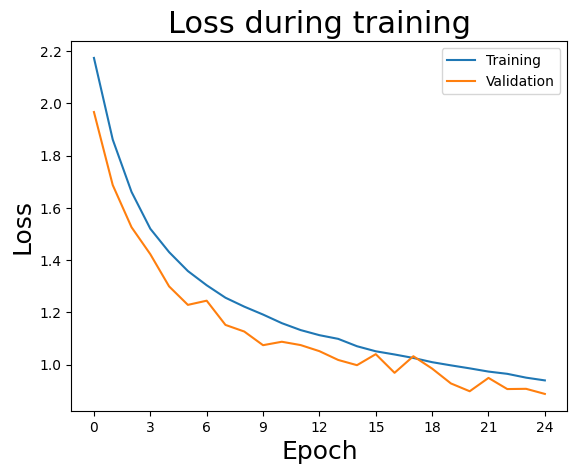

In [32]:
ax = utils.plot_loss_during_training(training_stats_dict)
plt.savefig("loss_during_training.png", dpi=300, format="PNG")

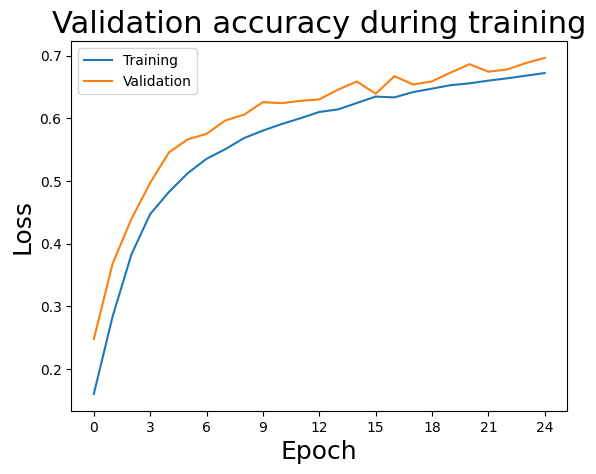

In [27]:
ax = utils.plot_accuracy_during_training(training_stats_dict)
plt.savefig("accuracy_during_training.png", dpi=300, format="PNG")

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [28]:
test_loss, test_accuracy, test_run_time = utils.get_model_performance_stats(model, criterion, validation_dataloader, device)

print(f"test loss:     {test_loss}")
print(f"test accuracy: {test_accuracy}")
print(f"test run time: {test_run_time}")

test loss:     0.8878414902505996
test accuracy: 0.6964
test run time: 1.1387197971343994


## Saving your model
Using `torch.save`, save your model for future loading.

In [29]:
importlib.reload(utils)
checkpoint_file_path = "checkpoint.pt"
utils.save_checkpoint(model, train_dataset, training_stats_dict, checkpoint_file_path)

In [30]:
# test loading saved model
loaded_model, loaded_other_params = utils.load_checkpoint(checkpoint_file_path)
loaded_model.to(device)

# verify loss and accuracy match what is expected on the test data
loaded_model_test_loss, loaded_model_test_accuracy, loaded_model_test_run_time = \
        utils.get_model_performance_stats(loaded_model, criterion, validation_dataloader, device)

print(f"loaded model test loss:     {loaded_model_test_loss}")
print(f"loaded model test accuracy: {loaded_model_test_accuracy}")
print(f"loaded model test run time: {loaded_model_test_run_time}")

loaded_training_stats_dict = loaded_other_params["training_stats_dict"]
loaded_num_epochs = len(loaded_training_stats_dict["training_avg_accuracies"])
print(f"loaded num epochs: {loaded_num_epochs}")

loaded model test loss:     0.8878414902505996
loaded model test accuracy: 0.6964
loaded model test run time: 1.0276122093200684
loaded num epochs: 25


## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

### Scenario
*Scenario You are a new machine learning engineer at a self-driving car startup. Management is trying to decide whether to build or buy an object detection algorithm for objects that may be on the side of the road. They are considering buying a computer vision algorithm from a company called Detectocorp. Detectocorp’s algorithm claims a 70% accuracy rate on the CIFAR-10 dataset, a benchmark used to evaluate the state of the art for computer vision systems.*

*But before making this purchase, management wants to explore whether you can build an in-house solution that performs well. They have asked you to try your hand at creating a neural network that can classify arbitrary objects and potentially be fine-tuned on a larger dataset using transfer learning.*

*Using the skills you’ve acquired building neural networks using PyTorch, your task is to build an image classifier using the CIFAR-10 dataset and evaluate its accuracy. Then you'll compare its performance to both Detectocorp’s algorithm (which achieved 70% accuracy) as well as the state of the art results detailed in the notebook—and make a recommendation to management about whether to build the solution in-house or buy the algorithm from Detectocorp.*

### My recommendation

My recommendation is to build an in-house solution (or investigate other vendors that have >70\% accuracy on the CIFAR-10 dataset).  With limited exploration, I was able to train a classifier that had 69.6\% accuracy on the test data.  This is quite close to the accuracy of the *Detectocorp* model, and it hadn't yet quite converged.  And other optimizations are still possible to achieve higher accuracies.

<img src="output/classifier05-nepochs_25-accuracy_during_training.png" alt="drawing" width="500"/>
<img src="output/classifier05-nepochs_25-loss_during_training.png" alt="drawing" width="500"/>

The state of the art image classifiers on the CIFAR-10 dataset achieve >90% accuracy on the CIFAR-10 dataset.  I would recommend looking to see whether any of these models are published under a license permitting their use by the company.  If none are available, multiple publications give a description how high performing models were trained (and sometimes the code is also published), which should allow for the company to reproduce the results.

| Accuracy | Publication |
| -------- | ----------- |
| 78.9% | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf) |
| 90.6% | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf) |
| 96.0% | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf) |
| 99.0% | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf) |
| 98.5% | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf) |

It would also be worth attempting transfer learning using one of the ImageNet-trained models (DenseNet, Resnet, Alexnet, VGG, etc) as the base model (similar to what was done in [this project](https://github.com/mrperkett/udacity-project-create-image-classifier)).